In [1]:
"""
phantom_demo.py
===============
Quick standalone script that
1. Generates a 2‑D Shepp–Logan phantom.
2. Simulates sinogram data (parallel‑beam).
3. Reconstructs the slice with
   • Filtered Back‑Projection (FBP),
   • PWLS‑Huber (≈ iDose⁴),
   • MBIR‑TV (≈ IMR).
4. Displays the ground truth and all three reconstructions side‑by‑side.

Run with
--------
$ python phantom_demo.py

Dependencies
------------
- numpy, matplotlib
- scikit‑image ≥ 0.23
- iterative_ct_reconstruction.py must be in the Python path.
"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import os

print("Current working directory:", os.getcwd())

# local module with the forward / back projectors and reconstructor classe

from new_files.iterative_ct_reconstruction import (
    forward_projection,
    back_projection,
    iDose
)


Current working directory: c:\Users\joche\OneDrive\Documenten\Universiteit_Utrecht\Master_Year_2\semester 2\inverse problems\big_project\Inverse_probelms_course


In [ ]:


###############################################################################
# Step 0 – configuration
###############################################################################

N = 256  # image size (NxN)
BETA_PWLS = 0.01
BETA_MTV = 0.002
N_ITER_PWLS = 40
N_ITER_MTV = 60


###############################################################################
# Step 1 – phantom and sinogram generation
###############################################################################

print("Generating Shepp–Logan phantom …")
im_gt = resize(shepp_logan_phantom(), (N, N), anti_aliasing=True)

# evenly spaced projection angles (parallel‑beam)
theta = np.linspace(0.0, 180.0, max(im_gt.shape), endpoint=False)
print(f"Using {len(theta)} projection angles …")

# simulate sinogram
a = forward_projection(im_gt, theta)
print("Sinogram shape:", a.shape)


###############################################################################
# Step 2 – reconstructions
###############################################################################

print("Running FBP …")
fbp = back_projection(a, theta, im_gt.shape, filter_name="ramp")

print("Running PWLS / iDose‑like …")
recon_pwls = iDose(theta).reconstruct(
    a, n_iter=N_ITER_PWLS, beta=BETA_PWLS
# )

# print("Running MBIR / IMR‑like …")
# recon_mbir = MBIRReconstructor(theta).reconstruct(
#     a, n_iter=N_ITER_MTV, beta=BETA_MTV
# )


###############################################################################
# Step 3 – visualization
###############################################################################

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for a_ in ax:
    a_.set_axis_off()

aX = [im_gt, fbp, recon_pwls, recon_mbir]
titles = [
    "Ground truth",
    "FBP",
    "PWLS / iDose‑like",
    "MBIR / IMR‑like",
]
for a_, img, title in zip(ax, aX, titles):
    im_ = a_.imshow(img, cmap="gray")
    a_.set_title(title)
fig.tight_layout()
plt.show()

print("Done!")


Generating Shepp–Logan phantom …
Using 256 projection angles …
Sinogram shape: (363, 256)
Running FBP …
Running PWLS / iDose‑like …


PWLS:   0%|          | 0/40 [00:06<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (514,256) (363,256) 

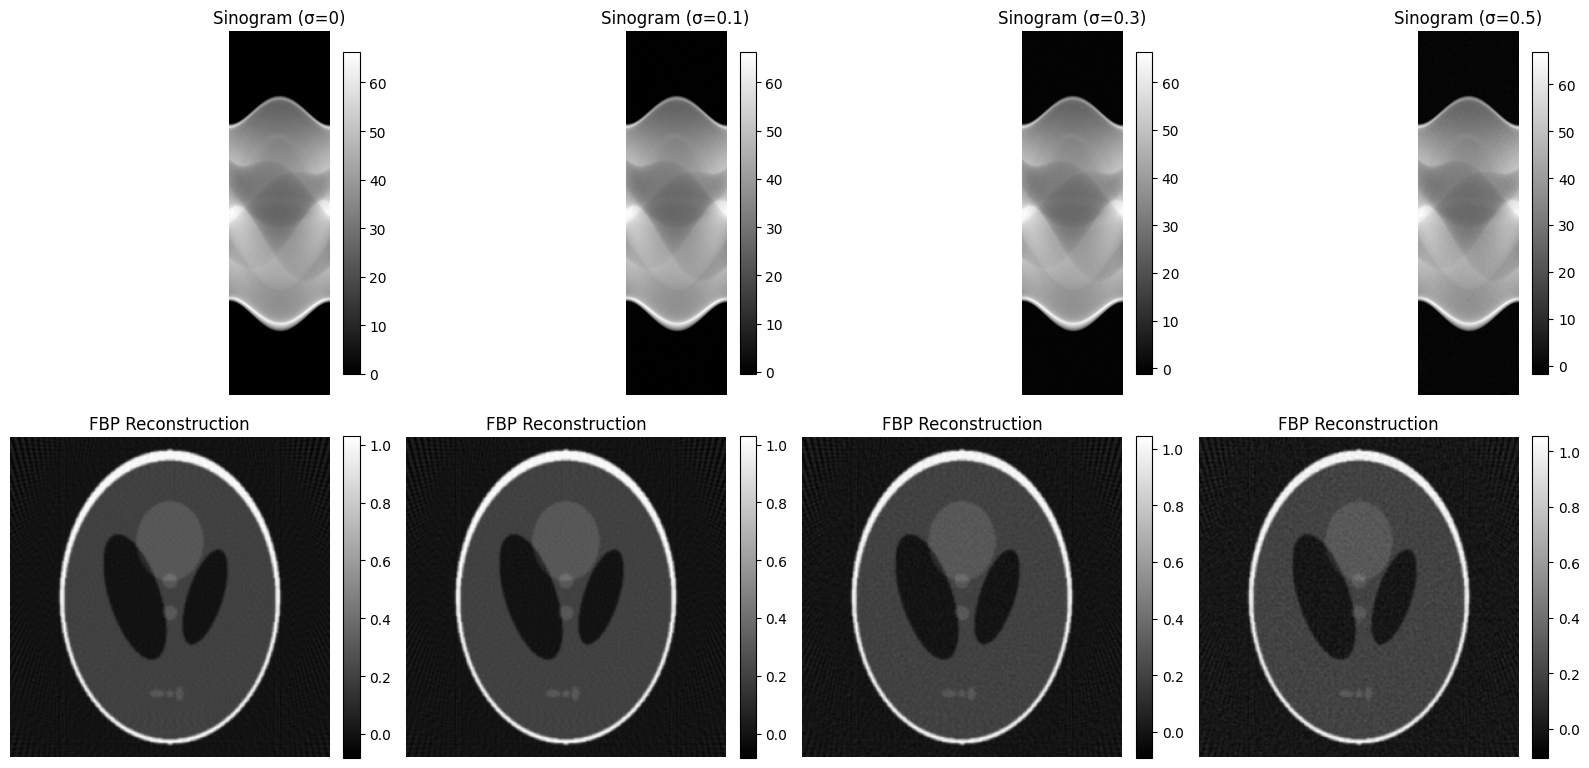

In [2]:
# Create noisy sinograms and reconstructions
noise_levels = [0, 0.1, 0.3, 0.5]  # Standard deviation for Gaussian noise

N = 256  # Image size (NxN)
# Define theta for the sinogram
num_angles = 100
theta = np.linspace(0.0, 180.0, num_angles, endpoint=False)

# Import shepp_logan_phantom
im_gt = resize(shepp_logan_phantom(), (N, N), anti_aliasing=True)

a = forward_projection(im_gt, theta)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, noise_level in enumerate(noise_levels):
    # Add noise to sinogram
    noisy_sinogram = a + np.random.normal(0, noise_level, a.shape)
    
    # Reconstruct with FBP
    fbp_noisy = back_projection(noisy_sinogram, theta, im_gt.shape, filter_name="cosine")
    
    # Plot sinogram
    im1 = axes[0,idx].imshow(noisy_sinogram, cmap='gray')
    axes[0,idx].set_title(f'Sinogram (σ={noise_level})')
    axes[0,idx].axis('off')
    plt.colorbar(im1, ax=axes[0,idx], fraction=0.046, pad=0.04)
    
    # Plot reconstruction
    im2 = axes[1,idx].imshow(fbp_noisy, cmap='gray')
    axes[1,idx].set_title(f'FBP Reconstruction')
    axes[1,idx].axis('off')
    plt.colorbar(im2, ax=axes[1,idx], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Saving every 10 iterations


IDose: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]


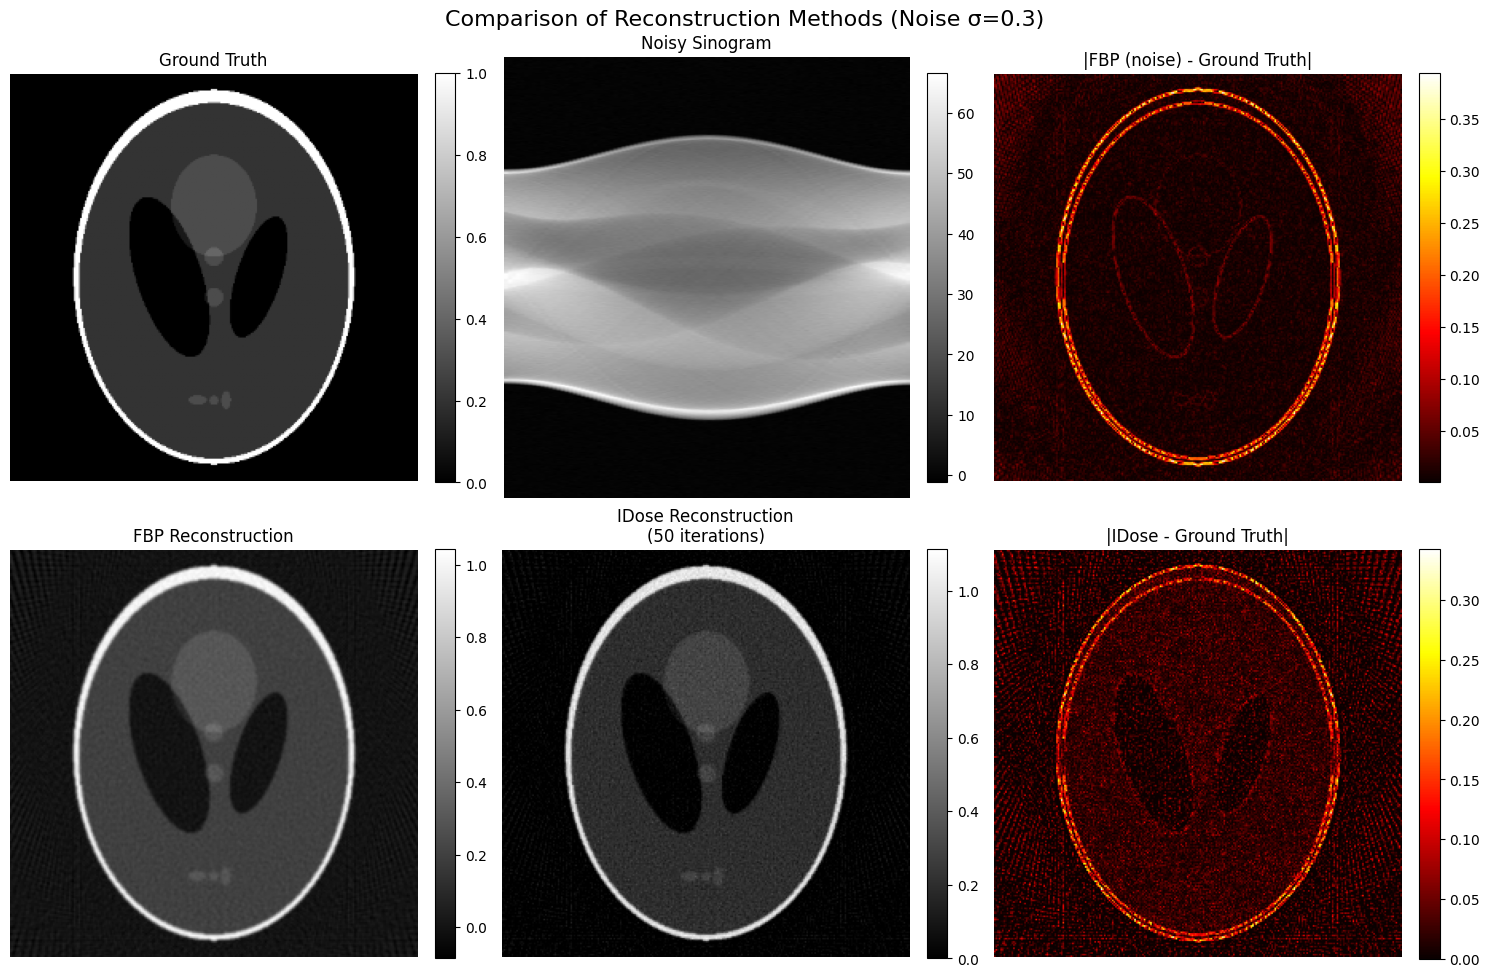

In [13]:
N = 256  # image size (NxN)
BETA = 10
N_ITER = 50
stepsize = 0.01



# Select a specific noise level for comparison
noise_level = 0.3

# Create noisy sinogram
noisy_sinogram = a + np.random.normal(0, noise_level, a.shape)

# Perform FBP and PWLS reconstructions
fbp_noisy = back_projection(noisy_sinogram, theta, im_gt.shape, filter_name="cosine")
pwls_noisy = iDose(theta).reconstruct(
    noisy_sinogram, n_iter=N_ITER, beta=BETA, prior = "cauchy", delta=0.01, step_size=stepsize
)

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f'Comparison of Reconstruction Methods (Noise σ={noise_level})', fontsize=16)

# Plot ground truth
im0 = axes[0,0].imshow(im_gt, cmap='gray')
axes[0,0].set_title('Ground Truth')
plt.colorbar(im0, ax=axes[0,0], fraction=0.046, pad=0.04)
axes[0,0].axis('off')

# Plot noisy sinogram
im1 = axes[0,1].imshow(noisy_sinogram, cmap='gray', aspect=0.3)
axes[0,1].set_title('Noisy Sinogram')
plt.colorbar(im1, ax=axes[0,1], fraction=0.046, pad=0.04)
axes[0,1].axis('off')

# Empty plot for symmetry
diff = np.abs(fbp_noisy - im_gt)
im5 = axes[0,2].imshow(diff, cmap='hot')
axes[0,2].set_title('|FBP (noise) - Ground Truth|')
plt.colorbar(im5, ax=axes[0,2], fraction=0.046, pad=0.04)
axes[0,2].axis('off')

# Plot FBP reconstruction
im3 = axes[1,0].imshow(fbp_noisy, cmap='gray')
axes[1,0].set_title('FBP Reconstruction')
plt.colorbar(im3, ax=axes[1,0], fraction=0.046, pad=0.04)
axes[1,0].axis('off')

# Plot PWLS reconstruction
im4 = axes[1,1].imshow(pwls_noisy[-1], cmap='gray')
axes[1,1].set_title(f'IDose Reconstruction\n({N_ITER} iterations)')
plt.colorbar(im4, ax=axes[1,1], fraction=0.046, pad=0.04)
axes[1,1].axis('off')

# Plot difference between PWLS and ground truth
diff = np.abs(pwls_noisy[-1] - im_gt)
im5 = axes[1,2].imshow(diff, cmap='hot')
axes[1,2].set_title('|IDose - Ground Truth|')
plt.colorbar(im5, ax=axes[1,2], fraction=0.046, pad=0.04)
axes[1,2].axis('off')

plt.tight_layout()
plt.show()